# HpyerOpt이용 하이퍼파라미터 튜닝

### < 하이퍼 파라미터 튜닝 방법>
1. `그리드서치`
2. `랜덤 서치`(그리드 서치를 랜덤하게)
3. `베이지안 최적화`
4. `수동튜닝`


Grid Search 방법 단점: 하이퍼 파라미터의 개수가 많을 경우 최적화 수행 시간이 오래걸림. XGBoost나 LightGBM은 하이퍼 파라미터 개수가 많기 때문에 그리드서치를 사용하여 하이퍼 파라미터 튜닝을 수행할 경우 시간이 오래걸림.

## 베이지안 최적화 개요

가능한 최소의 시도로 최적의 답을 찾아야 할 경우 사용시 효과적이다.

* `대체모델`(Surrogate Model) `획득함수`(Acquisition Function)로 구성
* 대체 모델은 획득 함수로부터 최적 입력 값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선
* 획득 함수는 개선된 대체 모델을 기반으로 다시 최적 입력 값을 계산


## 베이지안 최적화 단계

https://commons.wikimedia.org/wiki/File:GpParBayesAnimationSmall.gif

(1) 최초에 랜덤하게 하이퍼 파라미터 샘플링하고 성능 결과 관측

(2) 관측된 성능 결과를 기반으로 대체 모델은 최적 함수를 추정

(3) 추정된 최적 함수를 기반으로 획득함수는 다음으로 관측할 하이퍼 파라미터 값을 계산한다. 이전 최적 관측값보다 더 나은 성능 결과를 낼 것으로 추정되는 지점 하이퍼 파라미터를 다시 대체 모델로 전달한다.

(4) 획득 함수로부텉 전달된 하이퍼 파라미터로 모델 성능 결과를 관측하여 관층된 결과를 기반으로 대체 모델을 갱신해 다시 최적 함수를 예측. (3)과 (4)의 과정을 반복하며 정확한 최적 함수 추정


## * 대체 모델이 최적 함수를 추정할때 사용하는 알고리즘

일반적으로 `가우시안 프로세스`를 적용하지만 HpyerOpt에서는 `트리 파르젠 Estimator`를 사용함

## * 베이지안 최적화 기반 하이퍼 파라미터 튜닝을 지원하는 파이썬 패키지

`HyperOpt`,`Batesian Optimization`,`Optuna` 등이 있음. 다음의 패키지는 사용법이 유사함.

### < HyperOpt 로직 구성 >

HyperOpt는 다른 패키지와 다르게 목적 함수 반환값의 최댓값이 아닌 최솟값을 가지는 최적 입력값을 유추함

1. 입력변수명과 입력값의 검색공간 설정

2. 목적함수 설정

3. 목적함수의 반환 최솟값을 가지는 최적 입력값 유추

In [2]:
# pip install hyperopt

In [3]:
import hyperopt

In [4]:
from hyperopt import hp

## (1) 검색공간 설정
### 입력값의 검색 공간을 제공해주는 대표적 함수

`hp.quniform(label,low,high,q)`: 최소, 최대, 간격
    
`hp.uniform(label,low,high)`: 정규 분포 형태의 검색 공간

`hp.randint(lable, upper)`:랜덤한 정숫값의 검색공간 설정

`hp.loguniform(label,low,high)`: ext(),값을 반환하며,반환값의 log변환 된 값은 정규분포를 가지는 검색공간 설정

`hp.choice(label, option)`: 검색값이 문자열 또는 문자열과 숫자가 섞여있을때 사용

In [7]:
# 입력변수 x와 y설정
# 검색공간은 딕셔너리 형태로 지정해야한다.


# -10~10까지 1의 간격/ -15~15까지 1의 간격
search_space = {'x': hp.quniform('x', -10, 10, 1), 
                'y': hp.quniform('y', -15, 15, 1) }

## (2) 목적함수 설정


변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환

In [9]:
from hyperopt import STATUS_OK


def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

## (3) 목적함수의 반환 최솟값을 가지는 최적 입력값 유추


HyperOpt에서는 `fmin`함수로 이러한 기능 제공
* fmin(fn, space, algo, max_evals, trials,rstate)

`fn` = 목적함수 지정

`algo` = 베이지안 최적화에 적용할 알고리즘 기법 기본 toe.suggest로 TPE를 뜻함

`max_evals`= 최적 입력값을 찾기 위한 입력값 시도 횟수

`trials` = 목적함수 반환 결과를 젖아하는 객체 변수명 입력

`rstate` = random_state와 같은 기능

In [10]:
from hyperopt import fmin,tpe,Trials
import numpy as np

In [11]:
#  목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법으로 찾기

# 입력 결과값을 저장한 Trials 객체값 생성
trial_val = Trials()


# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 994.57trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [12]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 947.64trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [13]:
# 함수 수행시마다 반환되는 반환값을 저장한 객체 results
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 

print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [14]:
# Trials 객체의 vals 속성에 
# {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.

print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


# HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화


### 1. 형변환

HyperOpt의 입력값과 반환값은 모두 실수형이기때문에 모델에 따라 하이퍼 파라미터 입력시 정수형으로 형변환 작업이 필요할 수 있다.

### 2. 좋은 성능을 갖는 하이퍼파라미터값 찾기 


또한 HpyerOpt는 목적 함수 반환값의 최댓값이 아닌 최솟값을 가지는 최적 입력값을 유추 하기때문에 좋은 성능이 예상되는 값에 -1를 곱해야하는 과정이 필요함


목적 함수 반환값의 최댓값이 아닌 최솟값을 가지는 최적 입력값을 유추함

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [17]:
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [18]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [21]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [22]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

In [23]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 따라서 정수형으로 입력되어야하는 하이퍼 파라미터에 관해서 int()를 사용해 지정




def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    
    # 정확도는 높을수록 더 좋은 수치임. 
    # -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [25]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func, # 위에서 지정했던 목적함수 지정
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))

print("베이지안 최적화 기법을 사용해 찾은 최적의 하이퍼 파라미터")
print('best:', best)

100%|██████████| 50/50 [00:06<00:00,  7.19trial/s, best loss: -0.9670616939700244]
베이지안 최적화 기법을 사용해 찾은 최적의 하이퍼 파라미터
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [26]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [28]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29513
[15]	validation_0-logloss:0.11926	validation_1-logloss:0.28891
[1

[130]	validation_0-logloss:0.01639	validation_1-logloss:0.22934
[131]	validation_0-logloss:0.01634	validation_1-logloss:0.22987
[132]	validation_0-logloss:0.01629	validation_1-logloss:0.22927
[133]	validation_0-logloss:0.01624	validation_1-logloss:0.23076
[134]	validation_0-logloss:0.01620	validation_1-logloss:0.23030
[135]	validation_0-logloss:0.01615	validation_1-logloss:0.22891
[136]	validation_0-logloss:0.01610	validation_1-logloss:0.22883
[137]	validation_0-logloss:0.01606	validation_1-logloss:0.22882
[138]	validation_0-logloss:0.01601	validation_1-logloss:0.22876
[139]	validation_0-logloss:0.01597	validation_1-logloss:0.22734
[140]	validation_0-logloss:0.01592	validation_1-logloss:0.22882
[141]	validation_0-logloss:0.01588	validation_1-logloss:0.22935
[142]	validation_0-logloss:0.01583	validation_1-logloss:0.22880
[143]	validation_0-logloss:0.01579	validation_1-logloss:0.22856
[144]	validation_0-logloss:0.01575	validation_1-logloss:0.22725
[145]	validation_0-logloss:0.01571	valid

정확도가 약 0.9649로 하이퍼 파라미터 튜닝하지 않는 모델보다 약간 좋은 성능이 도출됨.

# 분류 실습


https://www.kaggle.com/competitions/santander-customer-satisfaction

캐글 산탄데르 고객 만족 예측

피처 이름이 모두 익명처리되어 어떤 피처인지 알 수 없음

불만고객 = 1 만족고객 = 0

성능평가는 ROC 곡선 영역으로 평가. 대부분이 만족이고 불만족인 데이터가 일부이기 때문에 ROC-AUC 평가방법이 더 적절하다고 판단

## 데이터 전처리

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [41]:
cust_df = pd.read_csv("train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [33]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [42]:
print(cust_df['TARGET'].value_counts())

print()
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64

unsatisfied 비율은 0.04


In [45]:
# 데이터 전처리


print(cust_df.var3.value_counts())
print()
print( "-999999은 Nan이나 특정값 에외값을 처리해 변환한 것으로 추정된다. 이는 다른 값에 피해 편차가 심하므로 가장 많은 값인 2로 변환한다")


 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

-999999은 Nan이나 특정값 에외값을 처리해 변환한 것으로 추정된다. 이는 다른 값에 피해 편차가 심하므로 가장 많은 값인 2로 변환한다


In [46]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]


print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [48]:
# 데이터 세트 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)


# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

[149]	validation_0-auc:0.90500	validation_1-auc:0.83353
[150]	validation_0-auc:0.90513	validation_1-auc:0.83352
[151]	validation_0-auc:0.90531	validation_1-auc:0.83349
[152]	validation_0-auc:0.90548	validation_1-auc:0.83349
[153]	validation_0-auc:0.90551	validation_1-auc:0.83351
[154]	validation_0-auc:0.90563	validation_1-auc:0.83348
[155]	validation_0-auc:0.90572	validation_1-auc:0.83343
[156]	validation_0-auc:0.90579	validation_1-auc:0.83344
[157]	validation_0-auc:0.90591	validation_1-auc:0.83345
[158]	validation_0-auc:0.90621	validation_1-auc:0.83355
[159]	validation_0-auc:0.90630	validation_1-auc:0.83359
[160]	validation_0-auc:0.90643	validation_1-auc:0.83356
[161]	validation_0-auc:0.90657	validation_1-auc:0.83352
[162]	validation_0-auc:0.90672	validation_1-auc:0.83346
[163]	validation_0-auc:0.90694	validation_1-auc:0.83347
[164]	validation_0-auc:0.90714	validation_1-auc:0.83343
[165]	validation_0-auc:0.90720	validation_1-auc:0.83343
[166]	validation_0-auc:0.90727	validation_1-auc:

In [50]:
print("하이퍼 파라미터 튜닝 전 모델의 정확도:")
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

하이퍼 파라미터 튜닝 전 모델의 정확도:
ROC AUC: 0.8429


## HyperOpt를 이용해 하이퍼파라미터 튜닝

In [52]:
# 검색공간 설정


# max_depth 5-15 1간격으로, min_child_weight 1-6 1간격으로, closample_bytree와 learning_rate는 구간에 맞는 정규분포된 값으로 검색

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 10, 1),
                'min_child_weight': hp.quniform('min_child_weight', 1,6, 1),
                   'closample_bytree': hp.uniform('closample_bytree', 0.5,0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01,0.2)
                   }

In [53]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

p.272부터

In [61]:
# 목적 함수 설정 

def objective_fn(search_space):
    xgb_clf = XGBClassifier(n_estimators =100, max_depth = int(search_space['max_depth']) ,
                           min_child_weight= int(search_space['min_child_weight']),
                            closample_bytree = search_space['closample_bytree'],
                            learning_rate =search_space['learning_rate']                 
                           )
    
    # 3개 k-fold방식으로 평가된 roc_auc 지표를 담는 list
    row_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits = 3)
    
    # 학습데이터 검증데이터 분리
    
    
        # XGBClassifier 학습 수행/ early_stopping 30회 설정
    
        # 1로 예측한 확률 값 추출 후 roc auc 계속하고 평균 roc auc 계산위해 list값에ㅠ담음
    

    
    # 3ro k-fold로 계산되니 roc_auc 값의 평균값을 반환하되,  HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1를 곱한뒤 반환
    return -1 * np.mean(roc_auc_list)

In [62]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(fn = objective_fn,
           space = xgb_search_space,
           algo = tpe.suggest,
           max_evals = 50,  # 최대 반복횟수
           trials = trials, rstate = np.random.default_rng(seed=30))

print("최적의 하이퍼 파라미터: ", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: name 'roc_auc_list' is not defined



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


NameError: name 'roc_auc_list' is not defined

In [ ]:
# 찾은 최적값 best를 search_space['']를 대체하여 넣는다 best['']로 대체

In [ ]:
# 최적의 파라미터를 가지고 모델 학습 후 성능 비교 

NameError: name 'plot_importance' is not defined

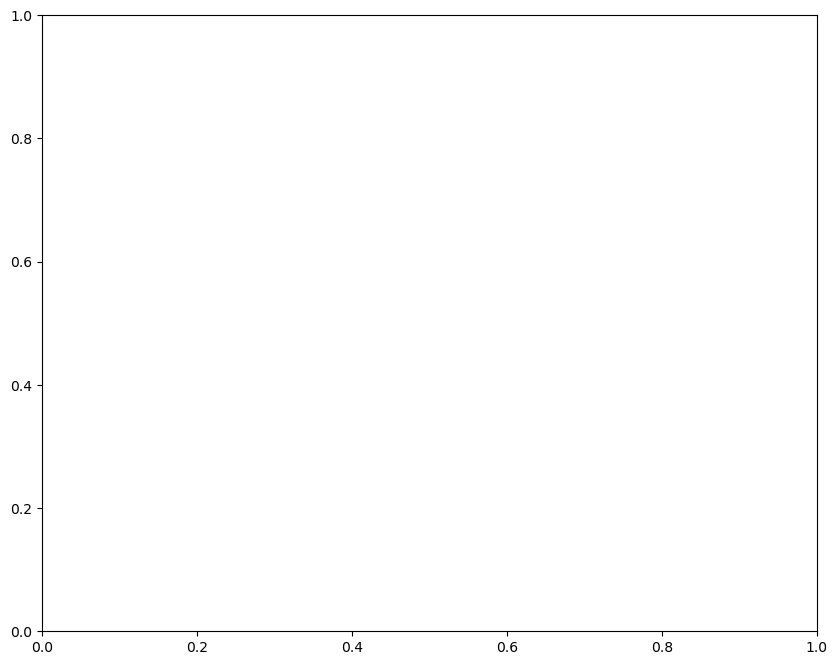

In [63]:
# feature importance 시각화

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax= ax, amx_num_features = 20, height = 0.4)